In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path
from collections import Counter
import hashlib

In [2]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
DATASET_PATH = "D:/KULIAH/SEMESTER 7/Skripsi/Dataset/dataset_trashnet"

In [4]:
# 1. LOAD DATASET

# Ambil daftar kelas
classes = sorted([d for d in os.listdir(DATASET_PATH) 
                  if os.path.isdir(os.path.join(DATASET_PATH, d))])

In [5]:
# Load semua path gambar dan labelnya
image_paths = []
labels = []
extensions = []

for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    images = [f for f in os.listdir(class_path) 
              if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    for img in images:
        image_paths.append(os.path.join(class_path, img))
        labels.append(class_name)
        extensions.append(os.path.splitext(img)[1].lower())

In [6]:
# Buat DataFrame
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels,
    'extension': extensions
})

In [8]:
all_files = []
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        all_files.append(file)

# Hitung duplikat
duplicates = [item for item, count in Counter(all_files).items() if count > 1]

print("Jumlah file duplikat berdasarkan nama:", len(duplicates))
print("Daftar file duplikat:", duplicates)

Jumlah file duplikat berdasarkan nama: 0
Daftar file duplikat: []


In [9]:
hashes = {}
duplicates = []

def hash_file(path):
    with open(path, "rb") as f:
        return hashlib.md5(f.read()).hexdigest()

for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        file_path = os.path.join(root, file)
        file_hash = hash_file(file_path)

        if file_hash in hashes:
            duplicates.append((file_path, hashes[file_hash]))
        else:
            hashes[file_hash] = file_path

print("Jumlah gambar duplikat berdasarkan konten:", len(duplicates))
for dup in duplicates:
    print("Duplikat:", dup)

Jumlah gambar duplikat berdasarkan konten: 0


In [7]:
# Hitung jenis file
ext_counts = df['extension'].value_counts()

print(f"Dataset berhasil dimuat!")
print(f"   Total gambar: {len(df)}")
print(f"   Jumlah kelas: {len(classes)}")
print(f"   Nama kelas: {classes}")
print(f"\n   Jenis file gambar:")
for ext, count in ext_counts.items():
    percentage = (count / len(df)) * 100
    print(f"      {ext:6} : {count:4} gambar ({percentage:.1f}%)")

Dataset berhasil dimuat!
   Total gambar: 2524
   Jumlah kelas: 6
   Nama kelas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

   Jenis file gambar:
      .jpg   : 2524 gambar (100.0%)


In [10]:
# 2. EDA - DISTRIBUSI DATA

# Hitung jumlah per kelas
class_counts = df['label'].value_counts().sort_index()

print("\nJumlah Data per Kelas:")
print("-" * 40)
for class_name, count in class_counts.items():
    percentage = (count / len(df)) * 100
    print(f"   {class_name:15} : {count:4} gambar ({percentage:.1f}%)")
print("-" * 40)
print(f"   {'TOTAL':15} : {len(df):4} gambar")


Jumlah Data per Kelas:
----------------------------------------
   cardboard       :  403 gambar (16.0%)
   glass           :  501 gambar (19.8%)
   metal           :  409 gambar (16.2%)
   paper           :  594 gambar (23.5%)
   plastic         :  480 gambar (19.0%)
   trash           :  137 gambar (5.4%)
----------------------------------------
   TOTAL           : 2524 gambar


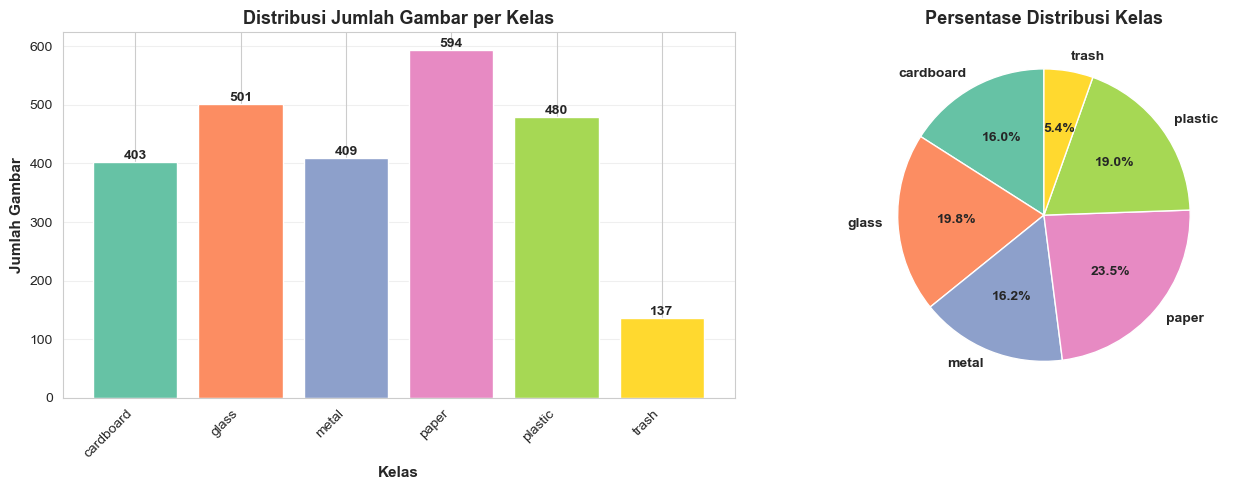

In [11]:
# Visualisasi distribusi
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
colors = sns.color_palette("Set2", len(class_counts))
bars = axes[0].bar(range(len(class_counts)), class_counts.values, color=colors)
axes[0].set_xticks(range(len(class_counts)))
axes[0].set_xticklabels(class_counts.index, rotation=45, ha='right')
axes[0].set_ylabel('Jumlah Gambar', fontsize=11, fontweight='bold')
axes[0].set_xlabel('Kelas', fontsize=11, fontweight='bold')
axes[0].set_title('Distribusi Jumlah Gambar per Kelas', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Tambah label di atas bar
for bar in bars:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontweight='bold')

# Pie chart
axes[1].pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
           startangle=90, colors=colors, textprops={'fontweight': 'bold'})
axes[1].set_title('Persentase Distribusi Kelas', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

In [12]:
# 3. EDA - PROPERTI GAMBAR

# analisis gambar
image_size = min(2524, len(df))
image_df = df.sample(n=image_size, random_state=42)

widths = []
heights = []
color_modes = []
extensions = []
sizes_kb = []

for img_path in image_df['image_path']:
    try:
        img = Image.open(img_path)
        widths.append(img.size[0])
        heights.append(img.size[1])
        color_modes.append(img.mode)
        extensions.append(os.path.splitext(img_path)[1].lower())
        sizes_kb.append(os.path.getsize(img_path) / 1024)
    except:
        continue

In [13]:
# Ringkasan properti
print(f"\nUkuran Gambar (dari {len(widths)} gambar):")
print(f"   Width  : Min={min(widths)}px, Max={max(widths)}px, Mean={np.mean(widths):.0f}px")
print(f"   Height : Min={min(heights)}px, Max={max(heights)}px, Mean={np.mean(heights):.0f}px")

print(f"\nTipe File Gambar:")
ext_counts = pd.Series(extensions).value_counts()
for ext, count in ext_counts.items():
    print(f"   {ext:10} : {count} gambar")

print(f"\nColor Mode:")
mode_counts = pd.Series(color_modes).value_counts()
for mode, count in mode_counts.items():
    print(f"   {mode:10} : {count} gambar")

print(f"\nUkuran File:")
print(f"   Min  : {min(sizes_kb):.1f} KB")
print(f"   Max  : {max(sizes_kb):.1f} KB")
print(f"   Mean : {np.mean(sizes_kb):.1f} KB")


Ukuran Gambar (dari 2524 gambar):
   Width  : Min=512px, Max=512px, Mean=512px
   Height : Min=384px, Max=384px, Mean=384px

Tipe File Gambar:
   .jpg       : 2524 gambar

Color Mode:
   RGB        : 2524 gambar

Ukuran File:
   Min  : 5.5 KB
   Max  : 56.5 KB
   Mean : 16.7 KB



Sample Gambar per Kelas:


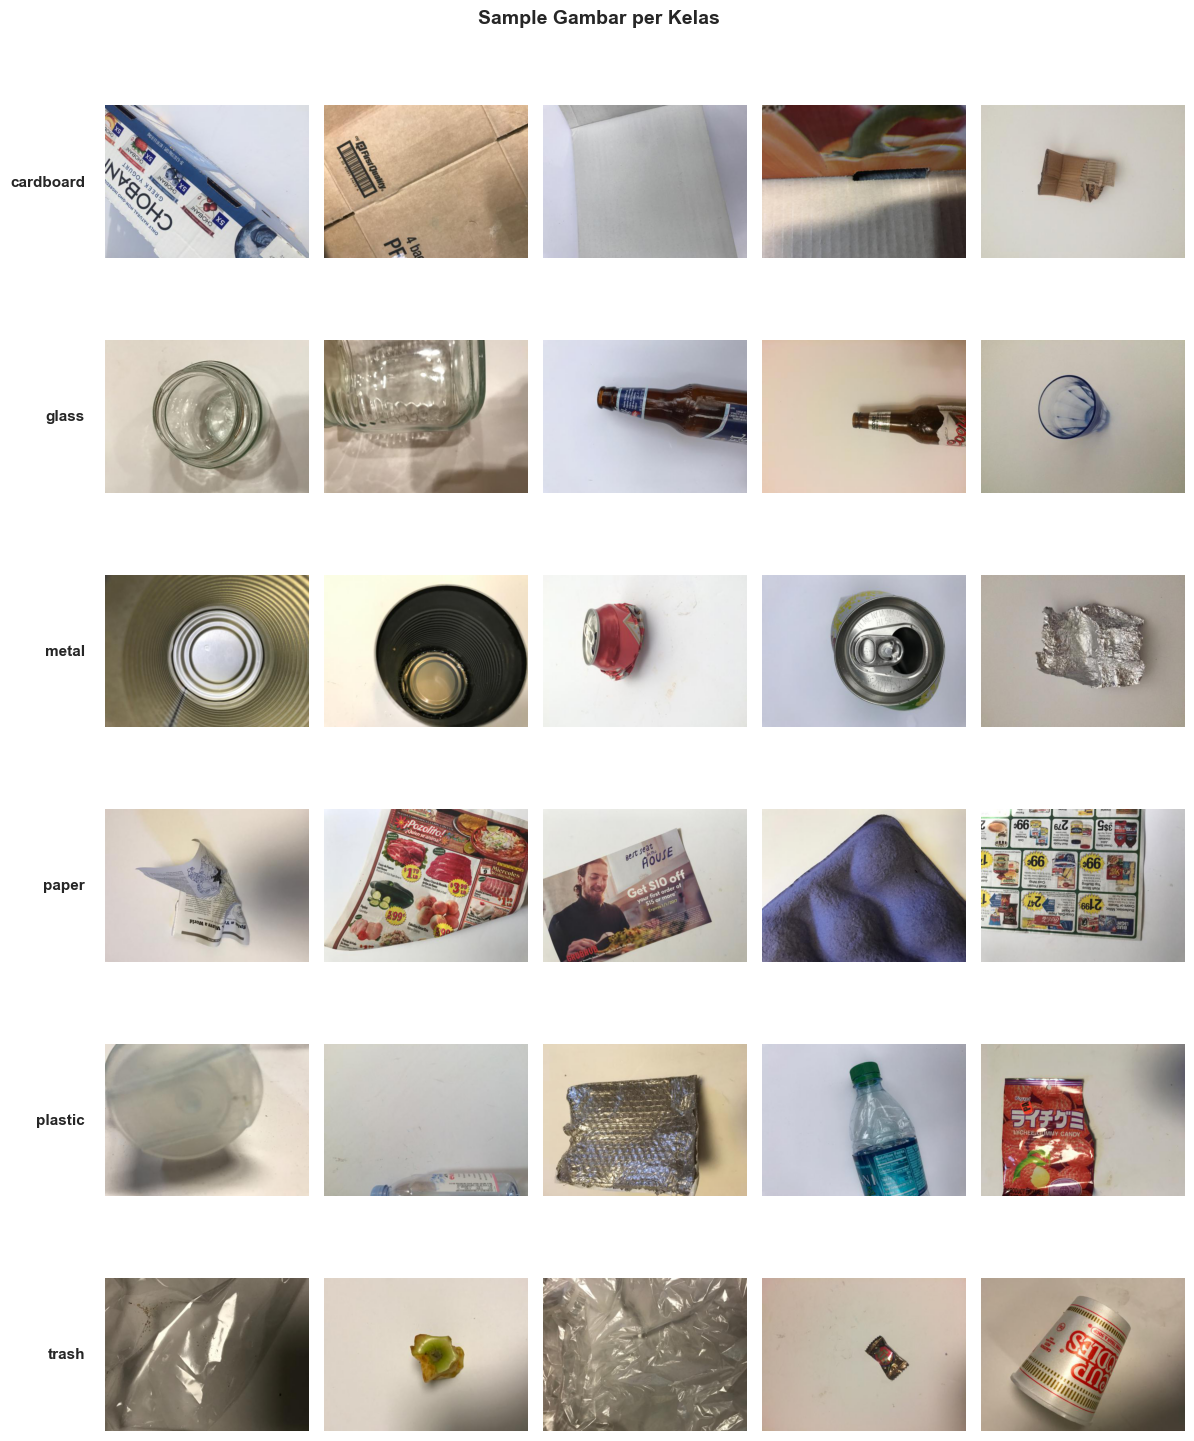

In [14]:
# 4. SAMPLE GAMBAR
print("\nSample Gambar per Kelas:")

n_samples = 5  # Jumlah sample per kelas
fig, axes = plt.subplots(len(classes), n_samples, figsize=(12, len(classes)*2.5))

for i, class_name in enumerate(classes):
    class_images = df[df['label'] == class_name].sample(n=n_samples, random_state=42)
    
    for j, (idx, row) in enumerate(class_images.iterrows()):
        img = Image.open(row['image_path'])
        
        if len(classes) == 1:
            ax = axes[j]
        else:
            ax = axes[i, j]
        
        ax.imshow(img)
        ax.axis('off')
        
        if j == 0:
            ax.text(-0.1, 0.5, class_name, transform=ax.transAxes,
                   fontsize=11, fontweight='bold', va='center', ha='right')

plt.suptitle('Sample Gambar per Kelas', fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [17]:
print("\nDataset Summary:")
print(f"   - Total data: {len(df)} gambar")
print(f"   - Jumlah kelas: {len(classes)}")
print(f"   - Ukuran rata-rata: {np.mean(widths):.0f}x{np.mean(heights):.0f} pixels")
print(f"   - Tipe file: {', '.join(ext_counts.index.tolist())}")
print(f"   - Color mode: {', '.join(mode_counts.index.tolist())}")

# Cek imbalance
imbalance_ratio = class_counts.max() / class_counts.min()
if imbalance_ratio > 1.5:
    print(f"\nPerhatian: Dataset tidak seimbang (ratio: {imbalance_ratio:.2f}x)")
    print("   - Gunakan data augmentation")
else:
    print(f"\nDataset seimbang (ratio: {imbalance_ratio:.2f}x)")

print("\nRekomendasi untuk MobileNet:")
print("   - Input size: 224x224")
print("   - Preprocessing: Resize + Normalisasi (0-1)")
print("   - Data split: 70% train, 15% val, 15% test")
print("   - Data augmentation: kenalin datset awal, gunakan augmentasi yang benar2 berguna")

print(f"\nDataset tersimpan dalam variabel: df")
print(f"Daftar kelas tersimpan dalam: classes")
print(f"Akses data: df['image_path'] dan df['label']")


Dataset Summary:
   - Total data: 2524 gambar
   - Jumlah kelas: 6
   - Ukuran rata-rata: 512x384 pixels
   - Tipe file: .jpg
   - Color mode: RGB

Perhatian: Dataset tidak seimbang (ratio: 4.34x)
   - Gunakan data augmentation

Rekomendasi untuk MobileNet:
   - Input size: 224x224
   - Preprocessing: Resize + Normalisasi (0-1)
   - Data split: 70% train, 15% val, 15% test
   - Data augmentation: kenalin datset awal, gunakan augmentasi yang benar2 berguna

Dataset tersimpan dalam variabel: df
Daftar kelas tersimpan dalam: classes
Akses data: df['image_path'] dan df['label']


In [16]:
# kenalin datset awal, gunakan augmentasi yang benar2 berguna